In [11]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from pathlib import Path
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import json
import random
import tqdm
from torch.autograd import Variable

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
class FoodDataset(Dataset):
    def __init__(self, root, mode='train', transforms=False, limit=None, scale=150, validation=False):
        assert mode in ['train', 'test'], "mode should be 'train' or 'test'"
        self.mode = mode  
        self.scale = scale
        self.transforms = transforms
        self.validation = validation
        
        ds_json = json.load(open(root + 'meta/meta/' + self.mode + ".json"))
                

        # Assuming the folder name is the class/label
        self.classes = set(ds_json.keys())
        self.label_to_index = {label: index for index, label in enumerate(self.classes)}
        self.index_to_label = {index: label for label, index in self.label_to_index.items()}
        
        self.images = []
        
        for k, vals in ds_json.items():
            for val in vals:
                self.images.append((
                    self.label_to_index[k], f"{root}images/{val}.jpg"
                ))
        
    def __getitem__(self, index):
        image_path, label = self.images[index][1], self.images[index][0]
        image = Image.open(image_path).convert('RGB')
        
        if self.transforms:
            t = self.random_transformations(self.scale)
            image = t(image)
            
        return image, label
            
    def __len__(self):
        return len(self.images)
    
    def random_transformations(self, scale):
        resize = T.Resize(scale)
        center_crop = T.CenterCrop(scale)
        rotation = T.RandomRotation(degrees=(0, 360))
        hori_flip = T.RandomHorizontalFlip(p=0.5)  # 50% chance of horizontal flip
        vert_flip = T.RandomVerticalFlip(p=0.2) # 20% chance to horizontal flip
        
        if self.validation:
            composed = T.Compose([
            resize, center_crop, T.ToTensor()
            ])
        else:
            composed = T.Compose([
                resize, center_crop, rotation, hori_flip, vert_flip, T.ToTensor()
            ])
        return composed


In [3]:
filepath = 'data/'
ds_train = FoodDataset(filepath, mode='train', transforms=True, scale=100)
ds_test = FoodDataset(filepath, mode='test', transforms=True, scale=100)

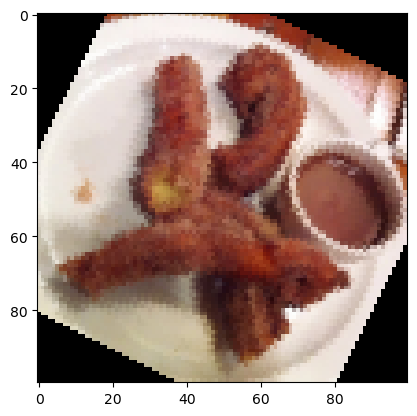

In [4]:
# Assuming ds_train is instantiated correctly with transform=True
image_tensor = ds_train[0][0]  # This should be a PyTorch tensor after ToTensor() transform
image_tensor = T.Resize((100, 100))(image_tensor)  # Resize the image
image_numpy = image_tensor.numpy()  # Convert to numpy array
image_numpy = image_numpy.transpose(1, 2, 0)  # Change from (C, H, W) to (H, W, C)

plt.imshow(image_numpy)
plt.show()

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                    dataloader = DataLoader(ds_train, batch_size=16, shuffle=True)
                    ds_size = len(ds_train)
                else:
                    model.eval()   # Set model to evaluate mode
                    dataloader = DataLoader(ds_test, batch_size=16, shuffle=True)
                    ds_size = len(ds_test)
                    

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                
                progress_bar = tqdm.tqdm(dataloader, desc=f"{phase} Epoch {epoch+1}/{num_epochs}", leave=False)
                for inputs, labels in progress_bar:
                    inputs = Variable(inputs)
                    labels = Variable(labels)
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    
                    progress_bar.set_postfix(loss=loss.item(), acc=torch.sum(preds == labels.data).item()/inputs.size(0))

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / ds_size
                epoch_acc = running_corrects.double() / ds_size

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(20, 10))
    ds_testing = FoodDataset(filepath, mode='test', transforms=True, scale=224, validation=True)
    dataloader = DataLoader(ds_testing, batch_size=4, shuffle=True)
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            preds = preds.cpu().data.numpy()
            labels = labels.cpu().data.numpy()

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {ds_testing.index_to_label[preds[j]]} -- True:{ds_testing.index_to_label[labels[j]]}')

                image_tensor = T.Resize((224, 224))(inputs.cpu().data[j])  # Resize the image
                image_numpy = image_tensor.numpy()  # Convert to numpy array
                image_numpy = image_numpy.transpose(1, 2, 0)  # Change from (C, H, W) to (H, W, C)

                plt.imshow(image_numpy)


                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [7]:
class ModifiedResNet(models.ResNet):
    def __init__(self, num_classes=1000, freeze_layers=True):
        # Initialize the original ResNet with predefined weights
        super(ModifiedResNet, self).__init__(block=models.resnet.BasicBlock, layers=[2, 2, 2, 2])
        self.load_state_dict(models.resnet18(pretrained=True).state_dict())
        
        if freeze_layers:
            for param in self.parameters():
                param.requires_grad = False
        
        # Add your additional module, e.g., a new conv layer
        self.layer5 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        
        # Modify the fully connected layer to match the number of classes
        self.fc = nn.Linear(256 , num_classes)

    def _forward_impl(self, x):
        # This is where you copy the original model's forward method
        # And insert the additional module where you want
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x) # additional layer
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model_ft = models.resnet18(weights='IMAGENET1K_V1')
model_ft = ModifiedResNet(num_classes=101, freeze_layers=False)
model_ft.load_state_dict(torch.load("resnet_save/train_5.pt"))


# Move the model to the configured device
model_ft = model_ft.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Since we have frozen the pretrained layers, only parameters of newly constructed modules have requires_grad=True
optimizer_ft = optim.SGD(filter(lambda p: p.requires_grad, model_ft.parameters()), lr=0.0001, momentum=0.9)

# Setup the learning rate scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=2)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)
torch.save(model_ft.state_dict(), "resnet_save/train_6.pt")

Epoch 0/4
----------


train Loss: 1.9314 Acc: 0.5079


val Loss: 1.6777 Acc: 0.5610

Epoch 1/4
----------


train Loss: 1.9044 Acc: 0.5154


val Loss: 1.6650 Acc: 0.5609

Epoch 2/4
----------


train Epoch 3/5:  98%|█████████▊| 4639/4735 [06:55<00:08, 11.54it/s, acc=0.562, loss=1.69] 

In [ ]:
torch.save(model_ft.state_dict(), "resnet_save/train_2.pt")

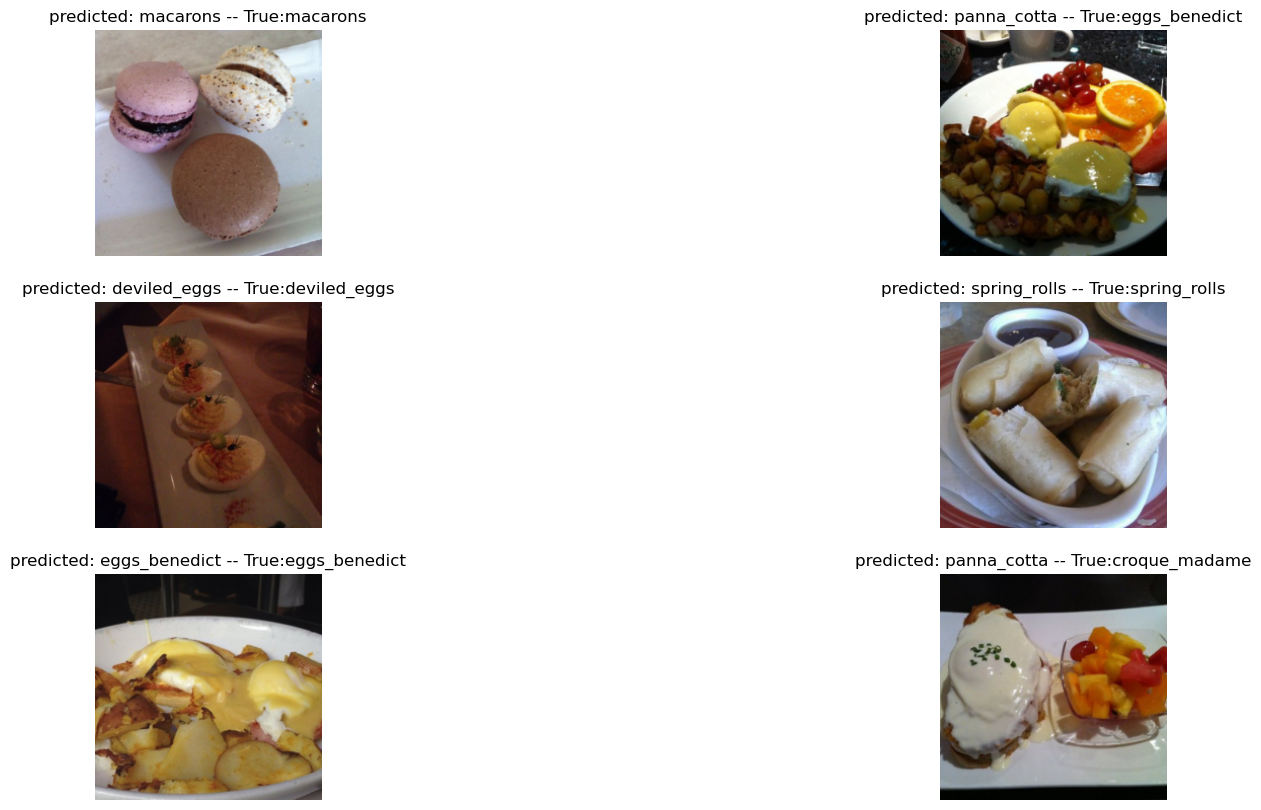

In [22]:
# model_ft = ModifiedResNet(num_classes=101)
# model_ft.load_state_dict(torch.load("resnet_save/train_2_PLUS_UNFROZEN_2.pt"))
# model_ft.eval()
# model_ft = model_ft.to(device)

visualize_model(model_ft)

In [12]:
import torch

if torch.cuda.is_available():
    gpu_count = torch.cuda.device_count()
    for i in range(gpu_count):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available. Listing CPU instead.")
    print(torch.__config__.parallel_info())


GPU 0: Tesla V100-SXM2-32GB
